In [1]:
!pip install -q transformers==4.37.2 --quiet
!pip install pydot --quiet

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from keras.callbacks import EarlyStopping

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from transformers import BertTokenizer, TFBertModel, AutoTokenizer, AutoModel

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
os.chdir('/content/drive/My Drive/w266_project')
df = pd.read_csv("features.csv", header = 0, sep="\t", index_col=0)

In [5]:
# Load SciBERT tokenizer and model
model_checkpoint = "allenai/scibert_scivocab_uncased"
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint, trainable=False, from_pt=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a 

In [6]:
big_countries = ['USA', 'Germany' 'Japan', 'Sweden', 'UK', 'Canada', 'Italy', 'Switzerland', 'France', 'China', 'Belgium', 'Netherlands', 'Australia', 'Spain',
'Poland', 'Austria', 'Denmark', 'Hungary','India','Finland','Taiwan', 'South Korea','Russia' ,'Czech Rep.']

df['Auth_country'] = df['Auth_country'].apply(lambda x: x if x in big_countries else 'other')

In [7]:
X = df[['Year Published', 'Cited Reference Count', 'Page Count', 'num_auth', 'num_words', 'Funding','Auth_country', 'Pub_country', 'Abstract', 'Document Title']]
y = df['JIF']

train_idx, val_idx, y_train, y_val = train_test_split(range(len(df)), y, test_size=0.3, random_state=42)

In [8]:
# Prepare categorical data
categories = ['Funding','Auth_country', 'Pub_country']
train_one_hot_data = {}
val_one_hot_data = {}
for cat in categories:
  one_hot_df = pd.get_dummies(df[cat], prefix=cat, dtype=int)
  train_one_hot_data[cat] = one_hot_df.iloc[train_idx]
  val_one_hot_data[cat] = one_hot_df.iloc[val_idx]

# Prepare numerical data
num_data = X[['Year Published', 'Cited Reference Count', 'Page Count', 'num_auth', 'num_words']]
scaler  = MinMaxScaler(feature_range=(0,1))
num_data = scaler.fit_transform(num_data)
train_num_data = num_data[train_idx]
val_num_data = num_data[val_idx]

### Model with text and metadata

In [9]:
[X['Abstract'].iloc[0], X['Document Title'].iloc[0]]

['The synthesis of the first high specific activity S-35-labeled hERG radioligand, [S-35]MK-0499, for use in HTS assays of drug candidates for hERG interaction is described. The radioligand is prepared by [S-35]sulfonylation of a high diastereomeric excess (de) aniline precursor prepared from unlabeled MK-0499.',
 'Synthesis of the first sulfur-35-labeled hERG radioligand']

In [12]:
i=0
max_length_abs = 400
max_length_tit = 50
val_abs_cls = np.empty((1,768))
train_abs_cls = np.empty((1,768))
val_tit_cls = np.empty((1,768))
train_tit_cls = np.empty((1,768))
encoding = bert_tokenizer([X['Abstract'].iloc[i], X['Document Title'].iloc[i]], truncation=True, padding=True, max_length=max_length_abs, return_tensors='tf')
bert_out = bert_model(encoding)
abs_cls = tf.reshape(bert_out[0][0,0,:], (1,768))
tit_cls = tf.reshape(bert_out[0][1,0,:], (1,768))
val_abs_cls = np.concatenate([val_abs_cls, abs_cls], axis = 0)
val_tit_cls = np.concatenate([val_tit_cls, tit_cls], axis = 0)

In [23]:
max_length_abs = 400
max_length_tit = 50
val_abs_cls = np.empty((1,768))
train_abs_cls = np.empty((1,768))
val_tit_cls = np.empty((1,768))
train_tit_cls = np.empty((1,768))
counter = 0
for i in val_idx:
  if counter%400 ==0:
    end = '\n'
  else:
      end = ', '
  if counter%20 ==0:
    print(counter, end = end)
  encoding = bert_tokenizer([X['Abstract'].iloc[i], X['Document Title'].iloc[i]], truncation=True, padding=True, max_length=max_length_abs, return_tensors='tf')
  bert_out = bert_model(encoding)
  abs_cls = tf.reshape(bert_out[0][0,0,:], (1,768))
  tit_cls = tf.reshape(bert_out[0][1,0,:], (1,768))
  val_abs_cls = np.concatenate([val_abs_cls, abs_cls], axis = 0)
  val_tit_cls = np.concatenate([val_tit_cls, tit_cls], axis = 0)
  counter+=1

counter = 0
for i in train_idx:
  if counter%400 ==0:
    end = '\n'
  else:
      end = ', '
  if counter%20 ==0:
    print(counter, end = end)
  encoding = bert_tokenizer([X['Abstract'].iloc[i], X['Document Title'].iloc[i]], truncation=True, padding=True, max_length=max_length_abs, return_tensors='tf')
  bert_out = bert_model(encoding)
  abs_cls = tf.reshape(bert_out[0][0,0,:], (1,768))
  tit_cls = tf.reshape(bert_out[0][1,0,:], (1,768))
  train_tit_cls = np.concatenate([train_tit_cls, tit_cls], axis = 0)
  train_abs_cls = np.concatenate([train_abs_cls, abs_cls], axis = 0)
  counter+=1

val_abs_cls = val_abs_cls[1:,:]
train_abs_cls = train_abs_cls[1:,:]
val_tit_cls = val_tit_cls[1:,:]
train_tit_cls = train_tit_cls [1:,:]

0
20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400
420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800
820, 840, 860, 880, 900, 920, 940, 960, 980, 1000, 1020, 1040, 1060, 1080, 1100, 1120, 1140, 1160, 1180, 1200
1220, 1240, 1260, 1280, 1300, 1320, 1340, 0
20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400
420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800
820, 840, 860, 880, 900, 920, 940, 960, 980, 1000, 1020, 1040, 1060, 1080, 1100, 1120, 1140, 1160, 1180, 1200
1220, 1240, 1260, 1280, 1300, 1320, 1340, 1360, 1380, 1400, 1420, 1440, 1460, 1480, 1500, 1520, 1540, 1560, 1580, 1600
1620, 1640, 1660, 1680, 1700, 1720, 1740, 1760, 1780, 1800, 1820, 1840, 1860, 1880, 1900, 1920, 1940, 1960, 1980, 2000
2020, 2040, 2060, 2080, 2100, 2120, 2140, 2160, 2180, 2200, 2220, 2240, 2260, 2280, 2300, 2320, 2340, 2360, 

In [30]:
hidden_size = 2019
dropout = 0.3
bert_model.trainable = False
learning_rate = 0.00002

num_of_levels  = df['Funding'].nunique()
#Jeremy Howard provides the following rule of thumb; embedding size = min(50, number of categories/2).
embedding_size = min(np.ceil((num_of_levels)/2), 50 )
embedding_size = int(embedding_size)

fund_input = keras.layers.Input(shape=(num_of_levels,), name = 'fund_input')
fund_emb = keras.layers.Embedding(input_dim=num_of_levels, output_dim=embedding_size, name = 'fund_emb')(fund_input)
fund_flat = keras.layers.Flatten(name = 'fund_flat')(fund_emb)
fund_flat = tf.keras.layers.Dropout(dropout)(fund_flat)

num_of_levels  = df['Auth_country'].nunique()
embedding_size = min(np.ceil((num_of_levels)/2), 50 )
embedding_size = int(embedding_size)

Auth_input = keras.layers.Input(shape=(num_of_levels,), name = 'Auth_input')
Auth_emb = keras.layers.Embedding(input_dim=num_of_levels, output_dim=embedding_size, name = 'Auth_emb')(Auth_input)
Auth_flat = keras.layers.Flatten(name = 'Auth_flat')(Auth_emb)
Auth_flat = tf.keras.layers.Dropout(dropout)(Auth_flat)

num_of_levels  = df['Pub_country'].nunique()
embedding_size = min(np.ceil((num_of_levels)/2), 50 )
embedding_size = int(embedding_size)

Pub_input = keras.layers.Input(shape=(num_of_levels,), name = 'Pub_input')
Pub_emb = keras.layers.Embedding(input_dim=num_of_levels, output_dim=embedding_size, name = 'Pub_emb')(Pub_input)
Pub_flat = keras.layers.Flatten(name = 'Pub_flat')(Pub_emb)
Pub_flat = tf.keras.layers.Dropout(dropout)(Pub_flat)

inp_num_data = keras.layers.Input(shape=(num_data.shape[1],), name = 'Num feat')

inp_abs_cls = keras.layers.Input(shape=(train_abs_cls.shape[1],), name = 'Abstract cls')
inp_tit_cls = keras.layers.Input(shape=(train_tit_cls.shape[1],), name = 'Title cls')

# Concatenate all layers
conc = keras.layers.Concatenate(name = 'concatenate')([inp_tit_cls, inp_abs_cls, Auth_flat, Pub_flat, fund_flat, inp_num_data])

hidden1 = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer1')(conc)
hidden1 = tf.keras.layers.Dropout(dropout)(hidden1)

# Create output layer
out = keras.layers.Dense(1, activation='linear', name = 'Regression_layer')(hidden1)
model = keras.Model(inputs=[inp_tit_cls, inp_abs_cls,
                            Auth_input, Pub_input, fund_input,
                            inp_num_data], outputs=out)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.metrics.mean_squared_error])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Auth_input (InputLayer)     [(None, 23)]                 0         []                            
                                                                                                  
 Pub_input (InputLayer)      [(None, 20)]                 0         []                            
                                                                                                  
 fund_input (InputLayer)     [(None, 2)]                  0         []                            
                                                                                                  
 Auth_emb (Embedding)        (None, 23, 12)               276       ['Auth_input[0][0]']          
                                                                                            

In [31]:
#Set up early stopping monitor
early_stopping = EarlyStopping(monitor='val_mean_squared_error',
                               patience=5,
                               mode = "auto",
                               restore_best_weights=True)

model.fit([ train_tit_cls, train_abs_cls,
           train_one_hot_data['Auth_country'], train_one_hot_data['Pub_country'], train_one_hot_data['Funding'],
           train_num_data],
           y_train,
           validation_data=([val_tit_cls, val_abs_cls,
                            val_one_hot_data['Auth_country'], val_one_hot_data['Pub_country'], val_one_hot_data['Funding'],
                            val_num_data],
                            y_val),
           batch_size=256, epochs=60, callbacks=[early_stopping])

Epoch 1/60
13/13 [==============================] - 2s 25ms/step - loss: 10.4763 - mean_squared_error: 10.4763 - val_loss: 4.9955 - val_mean_squared_error: 4.9955
Epoch 2/60
13/13 [==============================] - 0s 9ms/step - loss: 5.3554 - mean_squared_error: 5.3554 - val_loss: 4.8473 - val_mean_squared_error: 4.8473
Epoch 3/60
13/13 [==============================] - 0s 9ms/step - loss: 4.4171 - mean_squared_error: 4.4171 - val_loss: 4.3461 - val_mean_squared_error: 4.3461
Epoch 4/60
13/13 [==============================] - 0s 9ms/step - loss: 4.1909 - mean_squared_error: 4.1909 - val_loss: 3.9995 - val_mean_squared_error: 3.9995
Epoch 5/60
13/13 [==============================] - 0s 9ms/step - loss: 3.8895 - mean_squared_error: 3.8895 - val_loss: 3.8372 - val_mean_squared_error: 3.8372
Epoch 6/60
13/13 [==============================] - 0s 9ms/step - loss: 3.6611 - mean_squared_error: 3.6611 - val_loss: 3.7431 - val_mean_squared_error: 3.7431
Epoch 7/60
13/13 [===================

In [32]:
pred = model.predict([val_tit_cls, val_abs_cls,
                      val_one_hot_data['Auth_country'], val_one_hot_data['Pub_country'], val_one_hot_data['Funding'],
                      val_num_data])

43/43 [==============================] - 0s 2ms/step


Text(0, 0.5, 'Observed')

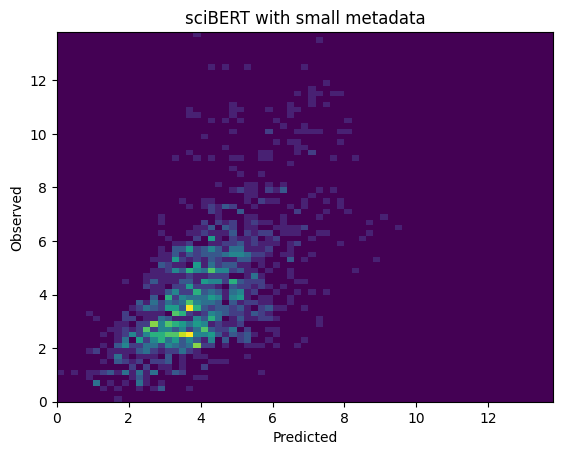

In [33]:
predictions = pred.reshape((-1))
fig, ax = plt.subplots()
ax.hist2d(predictions, y_val , bins=(np.arange(0, 14, 0.2), np.arange(0, 14, 0.2)))
ax.set_title('sciBERT with small metadata')
ax.set_xlabel('Predicted')
ax.set_ylabel('Observed')

In [34]:
np.corrcoef(predictions, y_val)

array([[1.        , 0.62458739],
       [0.62458739, 1.        ]])

In [ ]:
df_to_save = pd.DataFrame({'Observed':y_val, 'Predicted':predictions})
p = os.path.abspath('.')
file_path = os.path.join(p, 'results_csv', 'two_sciberts.csv')
df_to_save.to_csv(file_path, sep = '\t')